In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import random
from scipy.stats import multivariate_normal


In [47]:
!pip install openpyxl

In [48]:
def leer_csv(arch):
    clase1 = {'largo': [], 'ancho': []}
    clase2 = {'largo': [], 'ancho': []}

    with open(arch, 'r') as a:
        lines = a.readlines()
        for line in lines[1:]:
            line = line.rstrip()
            line = line.split(',')
            if line[0] == 'C1':
                clase1['largo'].append(float(line[1]))
                clase1['ancho'].append(float(line[2]))
            else:
                clase2['largo'].append(float(line[1]))
                clase2['ancho'].append(float(line[2]))

    return clase1, clase2

c1, c2 = leer_csv('dataset_hojas.csv')
largos = c1['largo'] + c2['largo']
anchos = c1['ancho'] + c2['ancho']
mu = np.array([[np.mean(c1['largo']), np.mean(c1['ancho'])], [np.mean(c2['largo']), np.mean(c2['ancho'])]])
sigma = np.array([np.cov(c1['largo'], c1['ancho']), np.cov(c2['largo'], c2['ancho'])])

/var/folders/3z/06g1pfs54j1f5897581mzyzw0000gq/T/ipykernel_8288/2352669631.py:14: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x, y, rv.pdf(pos), levels=lev , colors=f'C{k}', label=f'Normal {k+1}')


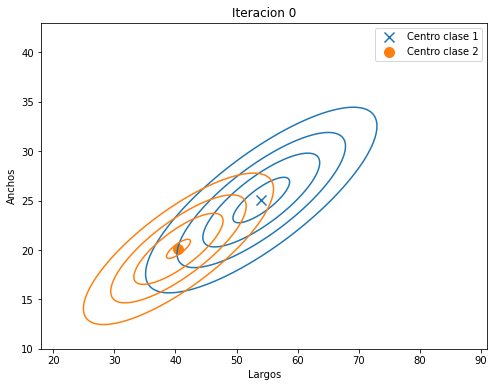

In [49]:
# 1. histograma de curvas de nivel de las dos gaussianas
def plot_data_and_normals(largos, anchos, mu, sigma, i, lev = 10, scat=True):
    plt.figure(figsize=(8, 6))
    
    #para plotear puntos del dataset
    if scat:
        plt.scatter(largos, anchos, c='blue', alpha=0.5)
    
    x, y = np.meshgrid(np.linspace(np.min(largos), np.max(largos), 1000), np.linspace(np.min(anchos), np.max(anchos), 1000))
    pos = np.dstack((x, y))
    
    for k in range(len(mu)):
        rv = multivariate_normal(mu[k], sigma[k])
        plt.contour(x, y, rv.pdf(pos), levels=lev , colors=f'C{k}', label=f'Normal {k+1}')

        if k == 0:
            plt.scatter(mu[k][0], mu[k][1], marker='x', color=f'C{k}', s=100, label=f'Centro clase {k+1}')
        else:
            plt.scatter(mu[k][0], mu[k][1], marker='o', color=f'C{k}', s=100, label=f'Centro clase {k+1}')
    
    
    plt.xlabel('Largos')
    plt.ylabel('Anchos')
    plt.legend()
    plt.title(f'Iteracion {i}' )
    plt.show()

plot_data_and_normals(largos, anchos, mu, sigma, 0, 4, False)

### E-Step:

$\gamma(z_{nk}) = \frac{\pi_k \mathcal{N}(x_n | \mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j \mathcal{N}(x_n | \mu_j, \Sigma_j)}$

In [51]:
def E_step(largos, anchos, mu, sigma, pi, K):
    """
    Realiza el paso E (Expectation) del algoritmo EM.

    Parámetros:
    - largos (list): Lista de dimensiones de largo.
    - anchos (list): Lista de dimensiones de ancho.
    - mu (numpy.ndarray): Matriz de medias de las distribuciones gaussianas.
    - sigma (numpy.ndarray): Matriz de covarianzas de las distribuciones gaussianas.
    - pi (numpy.ndarray): Vector de pesos de las distribuciones gaussianas.
    - K (int): Número de componentes en el modelo de mezcla gaussiana.

    Retorna:
    - numpy.ndarray: Matriz de responsabilidades.
    """
    N = len(largos)
    responsibilities = np.zeros((N, K))

    for i in range(N):
        for j in range(K):
            responsibilities[i, j] = pi[j] * multivariate_normal.pdf([largos[i], anchos[i]], mu[j], sigma[j])

        if np.sum(responsibilities[i, :]) != 0:
            responsibilities[i, :] /= np.sum(responsibilities[i, :])
        else:
            responsibilities[i, :] = 1/K

    return responsibilities

### M-Step:

\begin{align*}
\pi_k & = \frac{1}{N} \sum_{n=1}^{N} \gamma(z_{nk}) \\
\mu_k & = \frac{\sum_{n=1}^{N} \gamma(z_{nk}) x_n}{\sum_{n=1}^{N} \gamma(z_{nk})} \\
\Sigma_k & = \frac{\sum_{n=1}^{N} \gamma(z_{nk}) (x_n - \mu_k)(x_n - \mu_k)^\top}{\sum_{n=1}^{N} \gamma(z_{nk})}
\end{align*}

In [52]:
def M_step(largos, anchos, mu, sigma, pi, K, responsibilities):
    """
    Realiza el paso M (Maximization) del algoritmo EM.

    Parámetros:
    - largos (list): Lista de dimensiones de largo.
    - anchos (list): Lista de dimensiones de ancho.
    - mu (numpy.ndarray): Matriz de medias de las distribuciones gaussianas.
    - sigma (numpy.ndarray): Matriz de covarianzas de las distribuciones gaussianas.
    - pi (numpy.ndarray): Vector de pesos de las distribuciones gaussianas.
    - K (int): Número de componentes en el modelo de mezcla gaussiana.
    - responsibilities (numpy.ndarray): Matriz de responsabilidades.

    Retorna:
    - tuple: Nuevas medias, covarianzas y pesos de las distribuciones gaussianas.
    """
    new_mu = np.zeros((K, 2))
    new_sigma = np.zeros((K, 2, 2))
    new_pi = np.zeros(K)
    for k in range(K):
        new_mu[k] = np.sum(responsibilities[:, k][:, np.newaxis] * np.array([largos, anchos]).T, axis=0) / np.sum(responsibilities[:, k])
        new_sigma[k] = np.zeros((2, 2))
        for n in range(len(largos)):
            new_sigma[k] += responsibilities[n, k] * np.outer(np.array([largos[n], anchos[n]]) - new_mu[k], np.array([largos[n], anchos[n]]) - new_mu[k])
        new_sigma[k] /= np.sum(responsibilities[:, k])
        new_pi[k] = np.sum(responsibilities[:, k]) / len(largos)
    
    return new_mu, new_sigma, new_pi

### Log likelihood:

\begin{align*}
\text{log-likelihood}(\Theta) & = \sum_{n=1}^{N} \log \left( \sum_{k=1}^{K} \pi_k \mathcal{N}(x_n | \mu_k, \Sigma_k) \right)
\end{align*}

/var/folders/3z/06g1pfs54j1f5897581mzyzw0000gq/T/ipykernel_8288/2352669631.py:14: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x, y, rv.pdf(pos), levels=lev , colors=f'C{k}', label=f'Normal {k+1}')


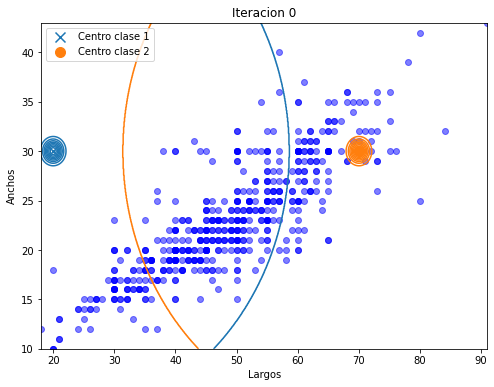

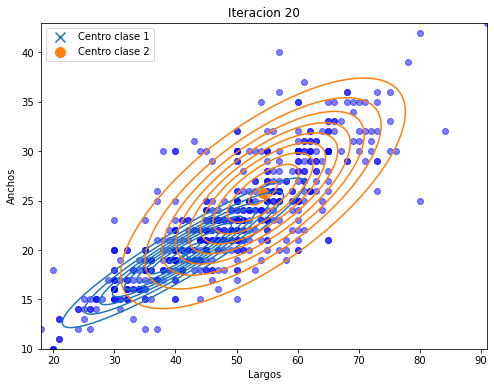

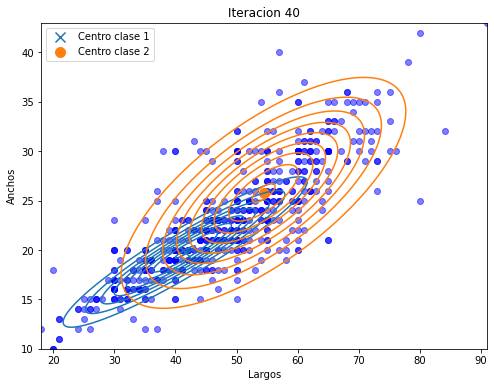

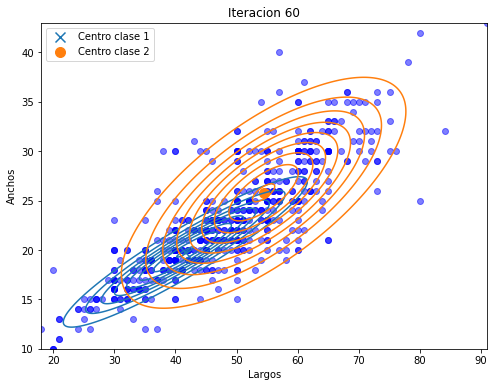

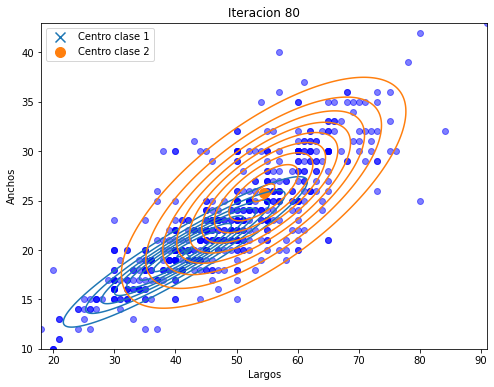

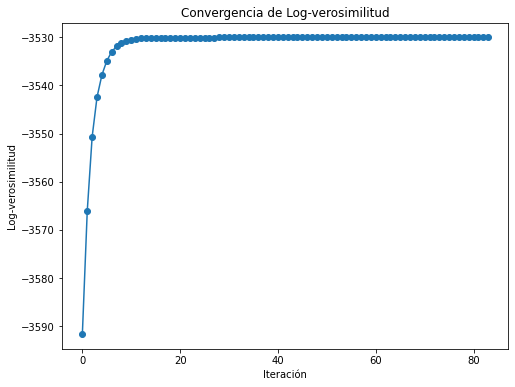

In [60]:
def EM(largos, anchos, max_iters=100, tol=1e-4):
    """
    Implementa el algoritmo Expectation-Maximization (EM) para clustering gaussiano.

    Parámetros:
    - largos (list): Lista de dimensiones de largo.
    - anchos (list): Lista de dimensiones de ancho.
    - K (int): Número de componentes en el modelo de mezcla gaussiana.
    - max_iters (int): Número máximo de iteraciones del algoritmo EM.
    - tol (float): Criterio de convergencia basado en cambios en la log-verosimilitud.

    Retorna:
    - tuple: Parámetros finales del modelo (mu, sigma, pi).
    """
    mu_0 = np.array([[20,30], [70,30]])
    sigma_0 = np.array([[[1, 0], [0, 0.5]], [[1, 0], [0, 0.5]]])  # definida positiva y simétrica
    pi_0 = np.array([0.4, 0.6])  # suman 1
    N = len(largos)
    K = 2
    mus, sigmas, pis = [], [], []
    log_likelihoods = []
    responsibilities = E_step(largos, anchos, mu_0, sigma_0, pi_0, K)
    plot_data_and_normals(largos, anchos, mu_0, sigma_0, 0)

    for i in range(1, max_iters):
        mu, sigma, pi = M_step(largos, anchos, mu_0, sigma_0, pi_0, K, responsibilities)

        # Calcular log-verosimilitud para verificar convergencia
        log_likelihood = 0
        for j in range(N):
            log_likelihood += np.log(np.sum([pi[k] * multivariate_normal.pdf([largos[j], anchos[j]], mu[k], sigma[k]) for k in range(K)]))

        log_likelihoods.append(log_likelihood)
        # Verificar convergencia
        if i > 1 and abs(log_likelihood - log_likelihoods[i-2]) < tol:
                break

        mus.append(mu)
        sigmas.append(sigma)
        pis.append(pi)
        responsibilities = E_step(largos, anchos, mu, sigma, pi, K)
        if i%20 == 0:
            plot_data_and_normals(largos, anchos, mu, sigma, i)
    return log_likelihoods

def plot_convergence(log_likelihoods):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(log_likelihoods, marker='o', linestyle='-')
    ax.set_xlabel('Iteración')
    ax.set_ylabel('Log-verosimilitud')
    ax.set_title('Convergencia de Log-verosimilitud')
    plt.show()


log_likelihoods = EM(largos, anchos)
plot_convergence(log_likelihoods)